# Multi-label mine classifier for India and Beyond

This notebook describes early steps to implement transfer learning on a Resnet model originally trained for the Planet Labs kaggle competition ["understanding the Amazon from space"](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). The data from the competition are still available [here](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data).

The idea is to explore the possibility of adjusting a very effective multi-label classifier to pick out one thing: mines. Seemingly moving from a couple dozen categories to two or so would be easy; the primary issue is that mines are much less common, which means a) there are fewer training images and b) the test set is much more imbalanced (most images will not have mines in them).

Further, the intention is to supplement the model with images of ~1,000 mines with known locations in India. Data augmentation techniques for these new images will provide us with a much better mine-centric training set, and help us transition the model towards our target: rural India.

## Where will the new imagery come from?

High-resolution satellite imagery is tough to come by when you can't pay for it. The Planet image chips from Kaggle are ~3-5m resolution. The closest I can get to that is the European Space Agency's Sentinel-2 mission, which has twin satellites beaming down RGB bands at approximately 10m resolution. These images are good enough to identify large-scale mines, which will be the target of this project. When higher-resolution data become available, the model can be adjusted to classify smaller "artisinal" mines as well.

The Sentinel imagery can be scraped from the Copernicus API, or a python API called [sentinelsat](https://pypi.org/project/sentinelsat/). This is super easy once you figure out how to navigate the ESA's documentation and vast array of imagery products. An true-color example of Sentinel-2A capturing a mine in Madhya Pradesh (western India) is below.

![mine](img/mine_ex.png)

## Sentinel processing

While the API is relatively simple to navigate in python, the Sentinel imagery is large and complex. Each tile is 100x100km, projected in WGS84, is 800mb, and requires the following processing steps:
- Chipping 4 bands (red, green, blue, and near-infrared) from our master tile images into smaller chips that the model can read (e.g. 200x200px)
- Categorizing each of these chips by their lat/lon information
- Labelling chips that contain known mines, using lat/lon information my research team has made available
- Chipping a matching .jpg for visual inspection (.jpgs included in Sentinel download)

I esimate that after cleaning, even only focusing on the state of Madhya Pradesh, the Sentinel imagery dataset would take up over 6TB of space. The extent of the Sentinel dataset I end up using will depend on the compute and storage resources available.

# Adjusting the Resnet

In the remaining steps of this notebook, I will transfer learn from a Resnet152 model trained on the Planet classification set to focus only on mines as described above. Once this model can be demonstrated to detect mines in the Amazon dataset, we can be reasonably assured it will provide a powerful foundation for the Indian case as well.

In [1]:
# a little python magic
%reload_ext autoreload
%autoreload 2
%matplotlib

Using matplotlib backend: MacOSX


In [5]:
# cd to the fastai directory so we can use the fastai module
cd ~/fastai/courses/dl1

SyntaxError: invalid syntax (<ipython-input-5-4a56cf04f4ce>, line 2)

In [2]:
# imports from the fast.ai package
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = 'data/planet/'

In [4]:
ls {PATH}

__MACOSX/                non_mining_files.csv  test_v2_file_mapping.csv
mine_files.csv           split_by_folder/      tmp/
mining_train_labels.csv  test-jpg/             train-jpg/
models/                  test-jpg-additional/  train_v2.csv


In [10]:
DIRPATH = 'data/planet/split_by_folder'

## Train our model
Set basic model specifications. The image labels depend on the directory structure.

In [14]:
sz=64
f_model=resnet152
data = ImageClassifierData.from_paths(DIRPATH, tfms=tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05))

In [15]:
data.classes

['mine', 'non_mine']

In [1]:
# initialize the learner with the above parameters
learn = ConvLearner.pretrained(f_model, data)

NameError: name 'ConvLearner' is not defined

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 525/632 [01:33<00:19,  5.60it/s, loss=0.374] 

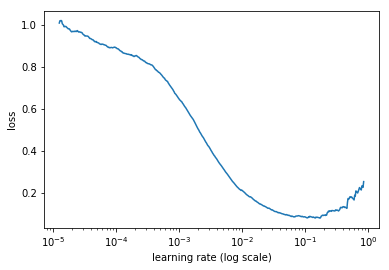

In [17]:
# plot how loss responds to learning rate, so we can specify lr favorably
lrf=learn.lr_find()
learn.sched.plot()

In [19]:
# set lr following the plot
lr = 0.003

In [20]:
# fit! specify the number of epochs
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  3%|▎         | 16/632 [00:04<02:43,  3.77it/s, loss=0.939]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                     
    0      0.056342   0.054104   0.985352  
    1      0.03188    0.043332   0.986979                     
    2      0.032727   0.042221   0.987956                     
    3      0.026433   0.038916   0.987956                     
    4      0.026204   0.039087   0.989258                     
    5      0.028647   0.038936   0.988281                     
    6      0.022937   0.036382   0.988932                     



[0.03638224, 0.9889322916666666]

In [21]:
# now let's do some learning rate annealing 
# start with larger rates to search more broadly across local minima, then decrease from there.
lrs=[lr/9,lr/3,lr]

In [22]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.026022   0.031258   0.992188  
    1      0.0186     0.028065   0.991862                     
    2      0.022319   0.027737   0.992513                     
    3      0.018618   0.030492   0.992188                     
    4      0.014854   0.029832   0.992839                     
    5      0.018139   0.029066   0.992188                      
    6      0.011389   0.028723   0.992839                      



[0.028722735, 0.9928385416666666]

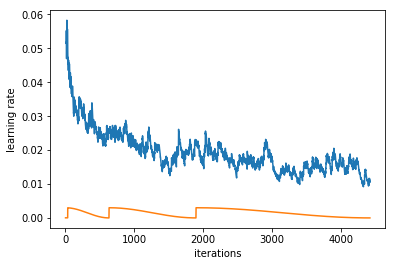

In [23]:
# save our progress, and plot our loss and learning rate
learn.save(f'mines_152_{sz}')
learn.sched.plot_loss()
learn.sched.plot_lr()

### Examine initial results

In [15]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(3050, 2)

In [17]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(non_mining)

In [24]:
# helper functions to provide some introspection into our predictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(DIRPATH+'/'+ds.fnames[idx]))

#def plot_val_with_title(idxs, title):
#    imgs = [load_img_id(data.val_ds,x) for x in idxs]
#    title_probs = [probs[x] for x in idxs]
#    print(title)
#    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

## Let's take a look at how we did
Use the plotting functions specified above to see some examples of images that the model specified correctly.
Also take a look at some that were incorrectly predicted.

Correctly classified


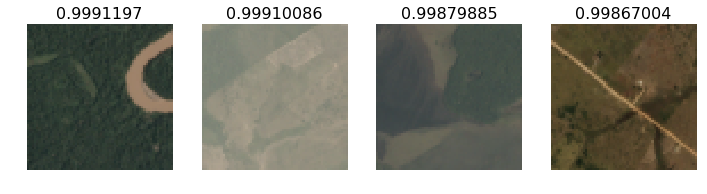

In [21]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


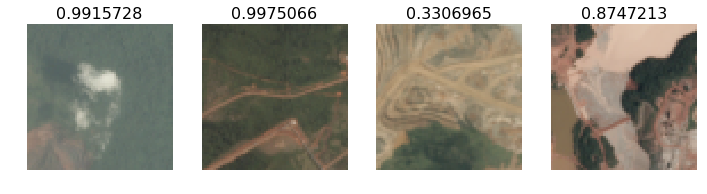

In [22]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [26]:
# these functions will give us the most incorrect and most correct predictions by category
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct mines


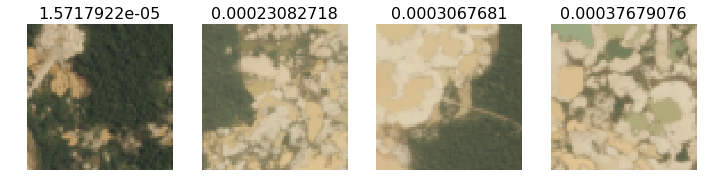

In [24]:
plot_val_with_title(most_by_correct(0, True), "Most correct mines")

Most correct non_mines


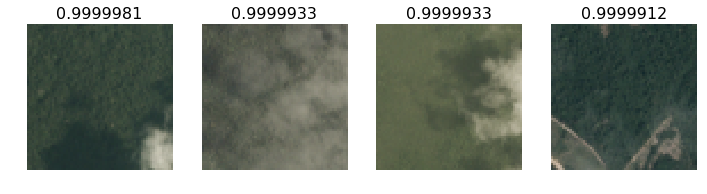

In [25]:
plot_val_with_title(most_by_correct(1, True), "Most correct non_mines")

Most incorrect mines


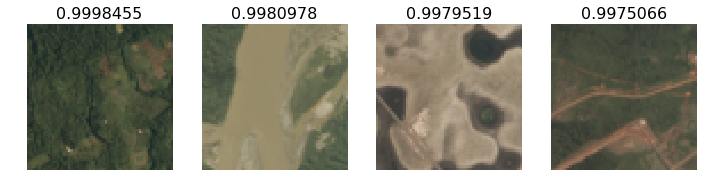

In [26]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect mines")

Most incorrect non_mines


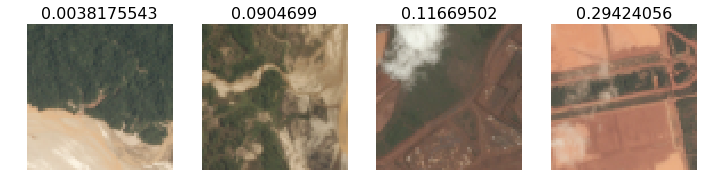

In [27]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect non_mines")

Most uncertain predictions


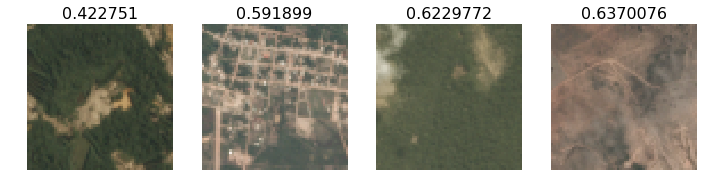

In [28]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [29]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [30]:
accuracy_np(probs, y)

0.9924590163934426

In [31]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

# PLOT 1:
## Confusion Matrix
The confusion matrix is incredibly important for imbalanced classification datasets - accuracy can be misleading. For example say that you have a dataset of 5,000 images with 5 mines and 4995 non-mines. If the model predicts all images as non-mine, the accuracy will be 0.999 - even though it predicted every mine incorrectly!

The confusion matrix lets you observe how each category was predicted. We can see below that we're finding about 60% of the mines, but without many false positives. We may wish to change this - false positives may be better than false negatives, as we could manually review the images the classifier finds as there aren't many mines overall. 

[[  31   19]
 [   4 2996]]


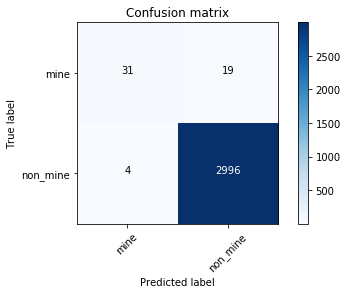

In [32]:
plot_confusion_matrix(cm, data.classes)

# Improve our model: larger images, more training

In [2]:
# expand the size of the CNN
sz=128

In [28]:
data = ImageClassifierData.from_paths(DIRPATH, tfms=tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05))
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.018837   0.030661   0.993164  
    1      0.017989   0.029691   0.991536                     
    2      0.015497   0.029897   0.991862                      
    3      0.017684   0.030317   0.992513                      
    4      0.014436   0.025127   0.992839                      
    5      0.010971   0.025998   0.992839                      
    6      0.010389   0.024428   0.992513                      



[0.024428247, 0.9925130208333334]

In [29]:
# unfreeze our model, re-train with the new parameters, and save it
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'mines_152_{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.012058   0.025718   0.99349   
    1      0.01124    0.025256   0.992839                      
    2      0.007733   0.025649   0.992513                      
    3      0.011436   0.024198   0.99349                       
    4      0.009656   0.024527   0.99349                       
    5      0.00759    0.023213   0.993815                      
    6      0.007545   0.024947   0.99349                       



In [30]:
# load our model
learn.load(f'mines_152_{sz}')

In [31]:
# expand the size and retrain again
sz = 256

In [32]:
data = ImageClassifierData.from_paths(DIRPATH, tfms=tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05))
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.010313   0.023382   0.993815  
    1      0.011895   0.024213   0.992839                      
    2      0.008252   0.022701   0.993164                      
    3      0.011836   0.021619   0.993815                      
    4      0.007775   0.022944   0.99349                       
    5      0.007029   0.022283   0.993815                      
    6      0.00821    0.022426   0.994141                      



[0.02242609, 0.994140625]

In [33]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'mines_152_{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.006898   0.023728   0.993815  
    1      0.00557    0.023957   0.994141                      
    2      0.003634   0.024506   0.994141                      
    3      0.00583    0.022366   0.99349                       
    4      0.004529   0.026032   0.993815                      
    5      0.005856   0.027474   0.992839                      
    6      0.005704   0.025668   0.994141                      



## Check our results again

In [ ]:
learn.load(f'mines_152_{sz}')

In [34]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9937704918032787

In [35]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
cm = confusion_matrix(y, preds)

[[  32   18]
 [   1 2999]]


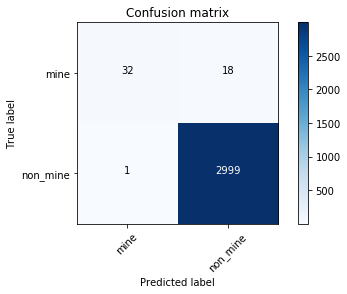

In [36]:
plot_confusion_matrix(cm, data.classes)

# Plot 2:
## Sets of images to examine our latest predictions
Below, we can see that the most correct mines are easily recognizable as surface mines with characteristic features of excavation - despite small amounts of cloud cover and varying degrees of haze. The most incorrect mines, however, would not even be recognizable as mines to the human eye. These mines are either misclassified or are mines that do not lead to characteristic land cover changes visible from space.

This is quite promising, and suggests that expanding the dataset to include images scraped for known mine locations in India would improve the accuracy of the model. Such a model should generalize well, and would be ready to roll out on a much larger test set to identify mines in entirely unknown areas.

Most correct mines


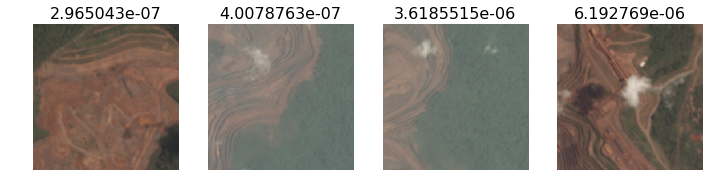

In [227]:
plot_val_with_title(most_by_correct(0, True), "Most correct mines")

Most incorrect mines


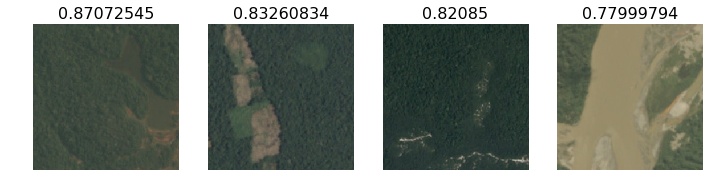

In [228]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect mines")

Most correct non_mines


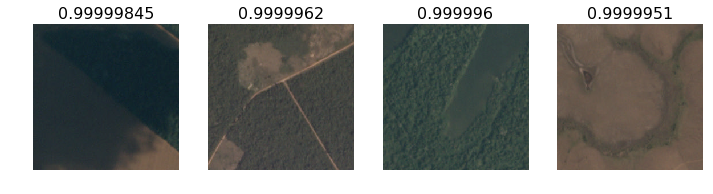

In [230]:
plot_val_with_title(most_by_correct(1, True), "Most correct non_mines")

Most incorrect non_mines


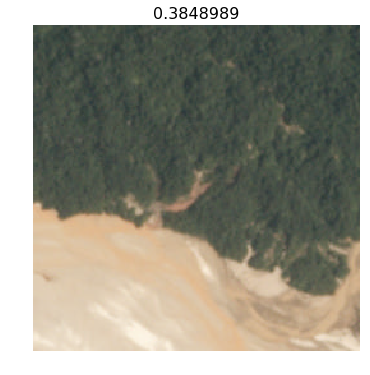

In [231]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect non_mines")

Most uncertain predictions


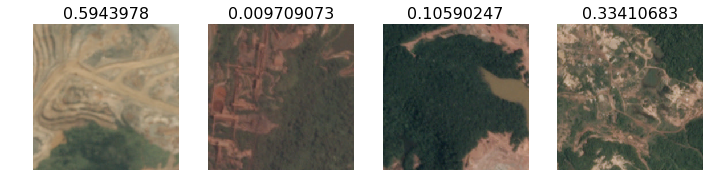

In [232]:
plot_val_with_title(most_uncertain, "Most uncertain predictions")

The presence of an easily identified mine among the most uncertain predictions indicates that there is still room for improvement. More data, and additional data augmentation techniques, should help significantly with this.